## Классификация многомерных объектов при наличии обучающей выборки

In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## a) Построение и тестирование классификатора с использованием модельных данных

In [2]:
dim = 3 # число признаков
n1 = 400 # объем первой выборки
n2 = 500 # объем второй выборки
n = 1000 # объем тестовой выборки

q_training1 = n1 / (n1 + n2) # доля данных в обучающей выборке, взятых из первого распределения
q_training2 = n2 / (n1 + n2) # доля данных в обучающей выборке - из второго распределения
q1 = 0.4 # доля данных в тестовой выборке - из первого распределения
q2 = 1 - q1 # доля данных в тестовой выборке - из второго распределения

# параметры распредеелний
mu1 = np.array([0, 1, -1.5])
mu2 = np.array([1.5, 1.5, -2])
cov_matrix_good = np.array([[1.2, 0.2, 0.5], [0.2, 0.7, 0.3], [0.5, 0.3, 0.9]]) # "хорошо" разделенные данные
cov_matrix_bad = cov_matrix_good * 10 # "плохо" разделенные данные

### Смоделируем обучающие и тестовые выборки

In [3]:
training_sample_good1 = multivariate_normal(mean=mu1, cov=cov_matrix_good).rvs(size=n1, random_state=123)
training_sample_good2 = multivariate_normal(mean=mu2, cov=cov_matrix_good).rvs(size=n2, random_state=123)
training_sample_marks = np.hstack((np.zeros(n1), np.ones(n2)))

test_sample_good = np.concatenate([multivariate_normal(mean=mu1, cov=cov_matrix_good).rvs(size=int(n * q1), random_state=345),
                                   multivariate_normal(mean=mu2, cov=cov_matrix_good).rvs(size=int(n * q2), random_state=345)],
                                   axis=0)

In [4]:
training_sample_bad1 = multivariate_normal(mean=mu1, cov=cov_matrix_bad).rvs(size=n1, random_state=123)
training_sample_bad2 = multivariate_normal(mean=mu2, cov=cov_matrix_bad).rvs(size=n2, random_state=123)

# test_sample_bad = np.concatenate([multivariate_normal(mean=mu1, cov=cov_matrix_bad).rvs(size=int(n * q1)), multivariate_normal(mean=mu2, cov=cov_matrix_bad).rvs(size=int(n * q2))], axis=0)
test_sample_bad = np.vstack((multivariate_normal(mean=mu1, cov=cov_matrix_bad).rvs(size=int(n * q1), random_state=345),
                             multivariate_normal(mean=mu2, cov=cov_matrix_bad).rvs(size=int(n * q2), random_state=345)))
test_sample_marks = np.hstack((np.zeros(int(n * q1)), np.ones(int(n * q2))))

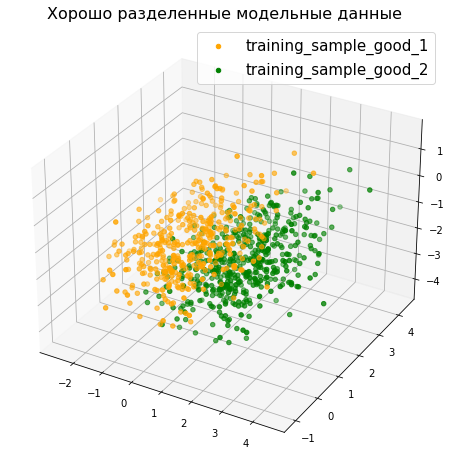

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=training_sample_good1[:, 0], ys=training_sample_good1[:, 1], zs=training_sample_good1[:, 2], c='orange', label='training_sample_good_1')
ax.scatter(xs=training_sample_good2[:, 0], ys=training_sample_good2[:, 1], zs=training_sample_good2[:, 2], c='g', label='training_sample_good_2')
# ax.scatter(xs=test_sample[:, 0], ys=test_sample[:, 1], zs=test_sample[:, 2], c='b', label='test_sample')

plt.legend(prop={'size': 15})
plt.title("Хорошо разделенные модельные данные", fontsize=16)
plt.show()

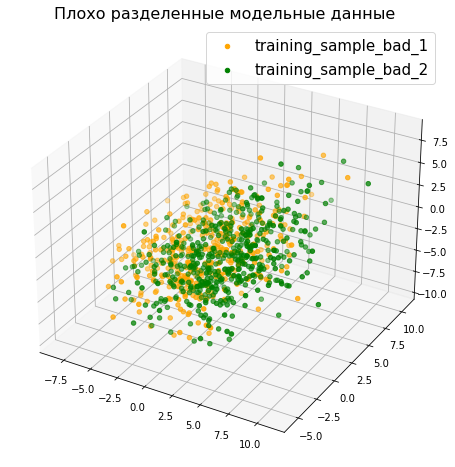

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=training_sample_bad1[:, 0], ys=training_sample_bad1[:, 1], zs=training_sample_bad1[:, 2], c='orange', label='training_sample_bad_1')
ax.scatter(xs=training_sample_bad2[:, 0], ys=training_sample_bad2[:, 1], zs=training_sample_bad2[:, 2], c='g', label='training_sample_bad_2')
# ax.scatter(xs=test_sample_bad[:, 0], ys=test_sample_bad[:, 1], zs=test_sample_bad[:, 2], c='b', label='test_sample_bad')

plt.legend(prop={'size': 15})
plt.title("Плохо разделенные модельные данные", fontsize=16)
plt.show()

### Вычислим выборочные оценки параметров распределений

In [7]:
def multivariate_mean(sample, size, dim_): # многомерное выборочное среднее
    mu = np.array([])
    for j in range(dim_):
        mu = np.append(mu, np.sum(sample[:, j]) / size)
    return mu

def sample_S(sample, size, mu_est, dim_): # выборочная ковариационная матрица
    S = np.zeros(shape=(dim_, dim_))
    for l in range(dim_):
        for j in range(dim_):
            S[l, j] = sum((sample[i, l] - mu_est[l])*(sample[i, j] - mu_est[j]) for i in range(size)) / (size - 1)
    return S

# усредненная выборочная ковариационная матрица
def multivariate_cov_matrix(sample1, sample2, size1, size2, multivariate_mu_est, dim_):
    S1 = sample_S(sample1, size1, multivariate_mu_est[0], dim_)
    S2 = sample_S(sample2, size2, multivariate_mu_est[1], dim_)

    S = ((size1 - 1) * S1 + (size2 - 1) * S2) / (size1 + size2 - 2)
    return S

In [8]:
mu1_good_est = multivariate_mean(training_sample_good1, n1, dim)
mu2_good_est = multivariate_mean(training_sample_good2, n2, dim)
mu_good_est = np.array([mu1_good_est, mu2_good_est])
# print(mu_est)
cov_matrix_good_est = multivariate_cov_matrix(training_sample_good1, training_sample_good2, n1, n2, mu_good_est, dim)

print(f"Заданные значения парметров распределений:\n Среднее: {mu1}, \n\t  {mu2}\n Ковариационная матрица:\n{cov_matrix_good}")
print(f"\nВыборочные оценки парметров распределений:\n Среднее: {mu_good_est[0]}, \n\t  {mu_good_est[1]}\n Ковариационная матрица:\n{cov_matrix_good_est}")

Заданные значения парметров распределений:
 Среднее: [ 0.   1.  -1.5], 
	  [ 1.5  1.5 -2. ]
 Ковариационная матрица:
[[1.2 0.2 0.5]
 [0.2 0.7 0.3]
 [0.5 0.3 0.9]]

Выборочные оценки парметров распределений:
 Среднее: [ 0.03259111  1.04239009 -1.47577711], 
	  [ 1.50272217  1.51016601 -1.99153676]
 Ковариационная матрица:
[[1.01133908 0.10557364 0.37990203]
 [0.10557364 0.7285143  0.26631713]
 [0.37990203 0.26631713 0.82720077]]


In [9]:
mu1_bad_est = multivariate_mean(training_sample_bad1, n1, dim)
mu2_bad_est = multivariate_mean(training_sample_bad2, n2, dim)
mu_bad_est = np.array([mu1_bad_est, mu2_bad_est])
# print(mu_est)
cov_matrix_bad_est = multivariate_cov_matrix(training_sample_bad1, training_sample_bad2, n1, n2, mu_bad_est, dim)

print(f"Заданные значения парметров распределений:\n Среднее: {mu1}, \n\t  {mu2}\n Ковариационная матрица:\n{cov_matrix_bad}")
print(f"\nВыборочные оценки парметров распределений:\n Среднее: {mu_bad_est[0]}, \n\t  {mu_bad_est[1]}\n Ковариационная матрица:\n{cov_matrix_bad_est}")

Заданные значения парметров распределений:
 Среднее: [ 0.   1.  -1.5], 
	  [ 1.5  1.5 -2. ]
 Ковариационная матрица:
[[12.  2.  5.]
 [ 2.  7.  3.]
 [ 5.  3.  9.]]

Выборочные оценки парметров распределений:
 Среднее: [ 0.10306214  1.13404925 -1.42340051], 
	  [ 1.50860827  1.53214776 -1.97323688]
 Ковариационная матрица:
[[10.11339075  1.05573639  3.7990203 ]
 [ 1.05573639  7.285143    2.66317129]
 [ 3.7990203   2.66317129  8.27200772]]


### Построим классификатор

In [10]:
def discriminant_fun(alpha, vect): # значение дискриминантной функции на векторе
    z = sum([a * x for a, x in zip(alpha, vect)])
    return z

# вычисление коэффициентов и среднего значения дискриминантной функции, порога принятия решения
def create_classifier(training1, training2, size1, size2, q1_, q2_, mu_est, cov_matrix_est):
    a = np.matmul(np.linalg.inv(cov_matrix_est), (mu_est[0] - mu_est[1]))
    mean_z1 = sum([discriminant_fun(a, training1[i, :]) for i in range(size1)]) / size1
    mean_z2 = sum([discriminant_fun(a, training2[i, :]) for i in range(size2)]) / size2
    mean_z = np.array([mean_z1, mean_z2])
    threshold = (mean_z1 + mean_z2) / 2.0 + np.log(q2_ / q1_)
    return a, mean_z, threshold

def classify(vect, alpha, threshold): # принятие решения о классе
    z = discriminant_fun(alpha, vect)
    if z >= threshold:
        return 0
    else:
        return 1

In [11]:
alpha_good, mean_z_good, threshold_good = create_classifier(training_sample_good1, training_sample_good2, n1, n2, q_training1, q_training2, mu_good_est, cov_matrix_good_est)
alpha_bad, mean_z_bad, threshold_bad = create_classifier(training_sample_bad1, training_sample_bad2, n1, n2, q_training1, q_training2, mu_bad_est, cov_matrix_bad_est)

### Оценим вероятности ошибочной классификации полученных классификаторов

In [12]:
def err_prob_est(m1, m2, size1, size2): # оценка по доле неправильных меток от размера выборки
    p21 = m1 / size1
    p12 = m2 / size2
    print(f"        P(2|1) = {p21:.5}")
    print(f"        P(1|2) = {p12:.5}")
    return p21, p12
    
def mahalanobis_biased_est(alpha, mean_z, cov_matrix_est): # смещенная оценка расстояния Махаланобиса
    dim_ = cov_matrix_est.shape[1]
    var_z = 0
    for l in range(dim_):
        for j in range(dim_):
            var_z += alpha[l] * cov_matrix_est[l, j] * alpha[j]

    return (mean_z[0] - mean_z[1]) ** 2 / var_z

def mahalanobis_unbiased_est(alpha, mean_z, cov_matrix_est, size1, size2): # несмещенная оценка расстояния Махаланобиса
    dim_ = cov_matrix_est.shape[1]
    D = mahalanobis_biased_est(alpha, mean_z, cov_matrix_est)
    D_unbiased = (size1 + size2 - dim_ - 3) * D / (size1 + size2 - 2) - dim_ * (1 / size1 +  1 / size2)
    return D_unbiased

def mahalanobis_err_prob_est(alpha, mean_z, cov_matrix_est, q1_, q2_): # оценка по расстоянию Махаланобиса
    K = np.log(q2_ / q1_)
    mah_biased_est = mahalanobis_biased_est(alpha, mean_z, cov_matrix_est)
    p21 = norm.cdf((K - 0.5 * mah_biased_est) / mah_biased_est ** 0.5)
    p12 = norm.cdf((-K - 0.5 * mah_biased_est) / mah_biased_est ** 0.5)
    print(f"        P(2|1) = {p21:.5}")
    print(f"        P(1|2) = {p12:.5}")
    return p21, p12

def overall_err_prob_est(p21, p12, q1_, q2_): # оценка общей вероятности ошибки
    return q1_ * p21 + q2_ * p12

##### Классифицируем обучающие выборки и найдем доли неправильно классифицированных объектов.

In [13]:
training_good_classification_res = np.array([])
training_bad_classification_res = np.array([])
training_sample_good = np.vstack((training_sample_good1, training_sample_good2))
training_sample_bad = np.vstack((training_sample_bad1, training_sample_bad2))

# Классифицируем обучающие выборки моделью, построенной по хорошо разделенным данным
for vect in training_sample_good:
    training_good_classification_res = np.append(training_good_classification_res, classify(vect, alpha_good, threshold_good))
cm_training_good = confusion_matrix(training_sample_marks, training_good_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_training_good.ravel()
m1_good = fp_1
m2_good = fn_1

# Классифицируем обучающие выборки моделью, построенной по плохо разделенным данным
for vect in training_sample_bad:
    training_bad_classification_res = np.append(training_bad_classification_res, classify(vect, alpha_bad, threshold_bad))
cm_training_bad = confusion_matrix(training_sample_marks, training_bad_classification_res)
tn_2, fp_2, fn_2, tp_2 = cm_training_bad.ravel()
m1_bad = fp_2
m2_bad = fn_2

Классификтор, построенный по хорошо разделенным данным:
	Оценка вероятности ошибочной классификации - доля неправильных меток:
        P(2|1) = 0.165
        P(1|2) = 0.136
	Оценка общей вероятности ошибочной классификации: 0.14889

	Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.16974
        P(1|2) = 0.12188
	Оценка общей вероятности ошибочной классификации: 0.14315

Классификатор, построенный по плохо разделенным данным:
	Оценка вероятности ошибочной классификации - доля неправильных меток:
        P(2|1) = 0.5125
        P(1|2) = 0.248
	Оценка общей вероятности ошибочной классификации: 0.36556

	Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.50725
        P(1|2) = 0.25197
	Оценка общей вероятности ошибочной классификации: 0.36543


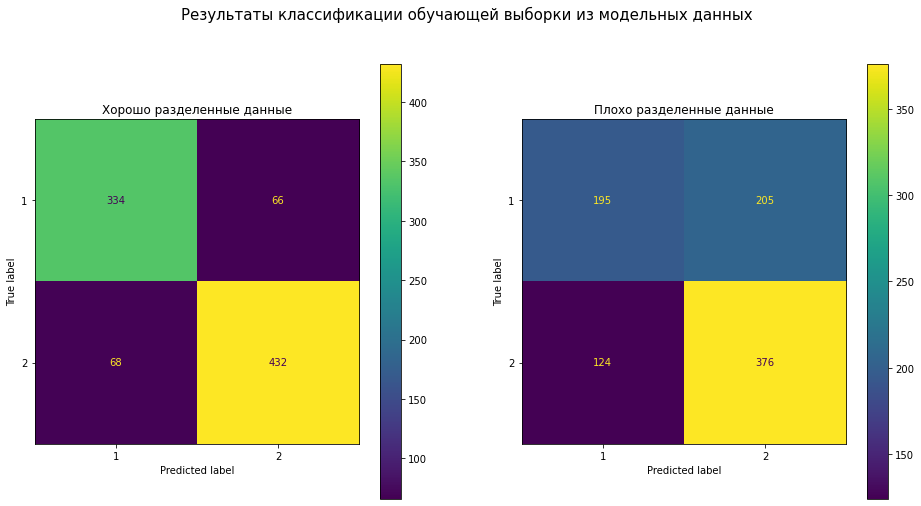

In [14]:
print("Классификтор, построенный по хорошо разделенным данным:")
print("\tОценка вероятности ошибочной классификации - доля неправильных меток:")
p21, p12 = err_prob_est(m1_good, m2_good, n1, n2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_training1, q_training2):.5}")
print("\n\tОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est(alpha_good, mean_z_good, cov_matrix_good_est, q_training1, q_training2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_training1, q_training2):.5}")

print("\nКлассификатор, построенный по плохо разделенным данным:")
print("\tОценка вероятности ошибочной классификации - доля неправильных меток:")
p21, p12 = err_prob_est(m1_bad, m2_bad, n1, n2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_training1, q_training2):.5}")
print("\n\tОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est(alpha_bad, mean_z_bad, cov_matrix_bad_est, q_training1, q_training2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_training1, q_training2):.5}")

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_good, display_labels=["1", "2"]).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix=cm_training_bad, display_labels=["1", "2"]).plot(ax=ax[1])
fig.suptitle("Результаты классификации обучающей выборки из модельных данных", fontsize=15)
ax[0].set_title("Хорошо разделенные данные")
ax[1].set_title("Плохо разделенные данные")
plt.show()

### Классифицируем тестовые выборки

In [15]:
good_classification_res = np.array([])
for vect in test_sample_good:
    good_classification_res = np.append(good_classification_res, classify(vect, alpha_good, threshold_good))

bad_classification_res = np.array([])
for vect in test_sample_bad:
    bad_classification_res = np.append(bad_classification_res, classify(vect, alpha_bad, threshold_bad))

cm_good = confusion_matrix(test_sample_marks, good_classification_res)
cm_bad = confusion_matrix(test_sample_marks, bad_classification_res)

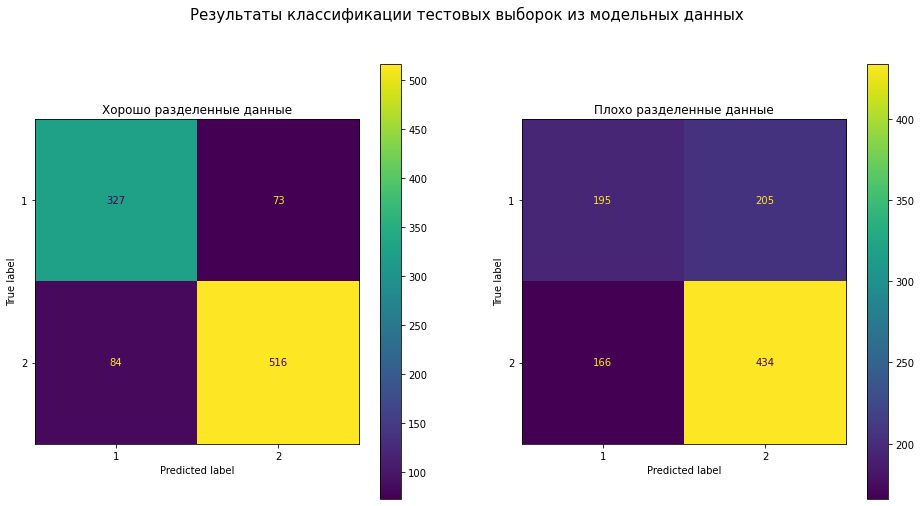

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_good, display_labels=["1", "2"]).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix=cm_bad, display_labels=["1", "2"]).plot(ax=ax[1])
fig.suptitle("Результаты классификации тестовых выборок из модельных данных", fontsize=15)
ax[0].set_title("Хорошо разделенные данные")
ax[1].set_title("Плохо разделенные данные")
plt.show()

In [17]:
tn_1, fp_1, fn_1, tp_1 = cm_good.ravel()
m1_good = fp_1
m2_good = fn_1

tn_2, fp_2, fn_2, tp_2 = cm_bad.ravel()
m1_bad = fp_2
m2_bad = fn_2

print("Эмпирические вероятности ошибочной классификации:\n\tКлассификтор, построенный по хорошо разделенным данным:")
p21, p12 = err_prob_est(m1_good, m2_good, n * q1, n  * q2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, q1, q2):.5}")

print("\n\tКлассификтор, построенный по плохо разделенным данным:")
p21, p12 = err_prob_est(m1_bad, m2_bad, n * q1, n  * q2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, q1, q2):.5}")

Эмпирические вероятности ошибочной классификации:
	Классификтор, построенный по хорошо разделенным данным:
        P(2|1) = 0.1825
        P(1|2) = 0.14
	Общая вероятность ошибочной классификации: 0.157

	Классификтор, построенный по плохо разделенным данным:
        P(2|1) = 0.5125
        P(1|2) = 0.27667
	Общая вероятность ошибочной классификации: 0.371


## Обучающие выборки большего объема

In [18]:
n1_small = 800 # объем первой обучающей выборки
n2_small = 1000 # объем второй обучающей выборки

q_small_train1 = n1_small / (n1_small + n2_small) # доля данных в обучающей выборке, взятых из первого распределения
q_small_train2 = n2_small / (n1_small + n2_small) # доля данных в обучающей выборке - из второго распределения

train_small1 = multivariate_normal(mean=mu1, cov=cov_matrix_good).rvs(size=n1_small, random_state=123)
train_small2 = multivariate_normal(mean=mu2, cov=cov_matrix_good).rvs(size=n2_small, random_state=123)
train_small_marks = np.hstack((np.zeros(n1_small), np.ones(n2_small)))

test_sample_small = np.concatenate([multivariate_normal(mean=mu1, cov=cov_matrix_good).rvs(size=int(n * q1), random_state=345),
                                   multivariate_normal(mean=mu2, cov=cov_matrix_good).rvs(size=int(n * q2), random_state=345)],
                                   axis=0)

### Вычислим выборочные оценки параметров распределений

In [19]:
mu1_small_est = multivariate_mean(train_small1, n1_small, dim)
mu2_small_est = multivariate_mean(train_small2, n1_small, dim)
mu_small_est = np.array([mu1_small_est, mu2_small_est])
# print(mu_est)
cov_matrix_small_est = multivariate_cov_matrix(train_small1, train_small2, n1_small, n2_small, mu_small_est, dim)

print(f"Заданные значения парметров распределений:\n Среднее: {mu1}, \n\t  {mu2}\n Ковариационная матрица:\n{cov_matrix_good}")
print(f"\nВыборочные оценки парметров распределений:\n Среднее: {mu_small_est[0]}, \n\t  {mu_small_est[1]}\n Ковариационная матрица:\n{cov_matrix_small_est}")

Заданные значения парметров распределений:
 Среднее: [ 0.   1.  -1.5], 
	  [ 1.5  1.5 -2. ]
 Ковариационная матрица:
[[1.2 0.2 0.5]
 [0.2 0.7 0.3]
 [0.5 0.3 0.9]]

Выборочные оценки парметров распределений:
 Среднее: [-0.00771188  1.00335296 -1.50994376], 
	  [ 1.86396917  1.88936091 -2.5017059 ]
 Ковариационная матрица:
[[1.14560302 0.22531019 0.33779937]
 [0.22531019 0.7866772  0.17802667]
 [0.33779937 0.17802667 0.98664074]]


### Построим классификатор

In [20]:
alpha_small, mean_z_small, threshold_small = create_classifier(train_small1, train_small2, n1_small, n2_small, q_small_train1, q_small_train2, mu_small_est, cov_matrix_small_est)

### Оценим вероятности ошибочной классификации полученного классификатора

In [21]:
train_small_classification_res = np.array([])
train_sample_small = np.vstack((train_small1, train_small2))

# Классифицируем обучающие выборки моделью, построенной по хорошо разделенным данным
for vect in train_sample_small:
    train_small_classification_res = np.append(train_small_classification_res, classify(vect, alpha_small, threshold_small))
cm_train_small = confusion_matrix(train_small_marks, train_small_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_train_small.ravel()
m1_small = fp_1
m2_small = fn_1

Классификтор, построенный по обучающим выборкам малого объема:
	Оценка вероятности ошибочной классификации - доля неправильных меток:
        P(2|1) = 0.1625
        P(1|2) = 0.123
	Оценка общей вероятности ошибочной классификации: 0.14056

	Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.23044
        P(1|2) = 0.15986
	Оценка общей вероятности ошибочной классификации: 0.19123


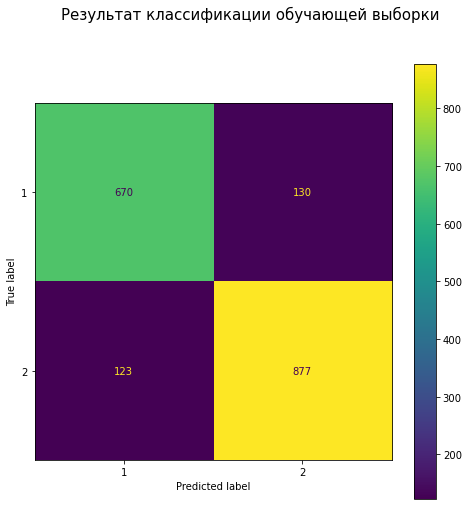

In [22]:
print("Классификтор, построенный по обучающим выборкам малого объема:")
print("\tОценка вероятности ошибочной классификации - доля неправильных меток:")
p21, p12 = err_prob_est(m1_small, m2_small, n1_small, n2_small)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_small_train1, q_small_train2):.5}")

print("\n\tОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est(alpha_small, mean_z_small, cov_matrix_small_est, q_small_train1, q_small_train2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_small_train1, q_small_train2):.5}")

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_train_small, display_labels=["1", "2"]).plot(ax=ax)
fig.suptitle("Результат классификации обучающей выборки", fontsize=15)
plt.show()

### Классифицируем тестовую выборку

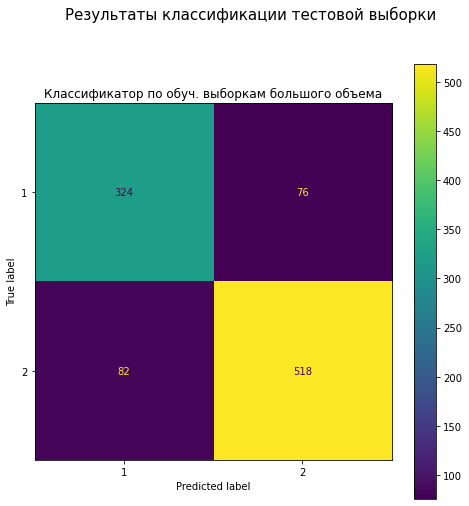

In [23]:
big_classification_res = np.array([])
for vect in test_sample_small:
    big_classification_res = np.append(big_classification_res, classify(vect, alpha_small, threshold_small))

cm_big = confusion_matrix(test_sample_marks, big_classification_res)

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_big, display_labels=["1", "2"]).plot(ax=ax)
fig.suptitle("Результаты классификации тестовой выборки", fontsize=15)
ax.set_title("Классификатор по обуч. выборкам большого объема")
plt.show()

In [24]:
tn_1, fp_1, fn_1, tp_1 = cm_big.ravel()
m1_big = fp_1
m2_big = fn_1

print("Эмпирические вероятности ошибочной классификации:")
p21, p12 = err_prob_est(m1_big, m2_big, n * q1, n  * q2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q1, q2):.5}")

Эмпирические вероятности ошибочной классификации:
        P(2|1) = 0.19
        P(1|2) = 0.13667
	Оценка общей вероятности ошибочной классификации: 0.158


## b) Построение и тестирование классификатора с использованием данных из репозитория

In [25]:
rep_dim = 24
rep_size = 1000
rep_train_part = 0.6
rep_test_part = 1 - rep_train_part

In [26]:
with open("german.data-numeric") as data:
    rep_objects = np.empty((0, rep_dim + 1))
    rep_marks = np.array([])
    for str in data:
        obj_str = str.split()
        rep_obj = list(map(float, obj_str))
        rep_objects = np.append(rep_objects, [rep_obj], axis=0)
        rep_marks = np.append(rep_marks, rep_obj[-1])

# Посмотрим на соотношение классов
size_1 = len(rep_objects[rep_marks == 1])
size_2 = len(rep_objects[rep_marks == 2])
print(f"В первом классе: {size_1} объектов\nВо втором классе: {size_2} объектов")

# Случайным образом разделяем данные на обучающую и тестовую выборку в заданном соотношении
rep_train_sample, rep_test_sample_ = train_test_split(rep_objects, train_size = rep_train_part, random_state = 12666) 
# Разделяем обучающие выборки по классам
rep_train_sample1 = np.array(rep_train_sample[rep_train_sample[:, -1] == 1, :-1])
rep_train_sample2 = np.array(rep_train_sample[rep_train_sample[:, -1] == 2, :-1])
rep_train_sample_marks = np.hstack((np.ones(rep_train_sample1.shape[0]), np.full(rep_train_sample2.shape[0], 2)))

rep_n1 = rep_train_sample1.shape[0]
rep_n2 = rep_train_sample2.shape[0]
print(f"Размер первой обучающей выборки: {rep_n1}\nРазмер второй обучающей выборки: {rep_n2}")
rep_q_training1 = rep_n1 / (rep_n1 + rep_n2)
rep_q_training2 = rep_n2 / (rep_n1 + rep_n2)
print(rep_q_training1,rep_q_training2)

# Выносим в отдельный вектор метки для проверки, убираем лишний столбец из признаков
rep_test_sample_marks = rep_test_sample_[:, -1]
rep_test_sample = rep_test_sample_[:, :-1]

В первом классе: 700 объектов
Во втором классе: 300 объектов
Размер первой обучающей выборки: 408
Размер второй обучающей выборки: 192
0.68 0.32


### Строим классификатор по данным из репозиторя

In [27]:
mu1_rep_est = multivariate_mean(rep_train_sample1, rep_n1, rep_dim)
mu2_rep_est = multivariate_mean(rep_train_sample2, rep_n2, rep_dim)
mu_rep_est = np.array([mu1_rep_est, mu2_rep_est])
cov_matrix_rep_est = multivariate_cov_matrix(rep_train_sample1, rep_train_sample2, rep_n1, rep_n2, mu_rep_est, rep_dim)

alpha_rep, mean_z_rep, threshold_rep = create_classifier(rep_train_sample1, rep_train_sample2, rep_n1, rep_n2, rep_q_training1, rep_q_training2, mu_rep_est, cov_matrix_rep_est)

### Оценим вероятности ошибочной классификации полученного классификатора

##### Классифицируем обучающие выборки и найдем доли неправильно классифицированных объектов.

In [28]:
training_rep_classification_res = np.array([])

training_sample_rep = np.vstack((rep_train_sample1, rep_train_sample2))

for vect in training_sample_rep:
    training_rep_classification_res = np.append(training_rep_classification_res, classify(vect, alpha_rep, threshold_rep))
    
training_rep_classification_res = training_rep_classification_res + 1
cm_training_rep = confusion_matrix(rep_train_sample_marks, training_rep_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_training_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

Оценка вероятности ошибочной классификации - доля неправильных меток:
        P(2|1) = 0.1348
        P(1|2) = 0.50521
	Оценка общей вероятности ошибочной классификации: 0.25333

Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.10901
        P(1|2) = 0.53949
	Оценка общей вероятности ошибочной классификации: 0.24676


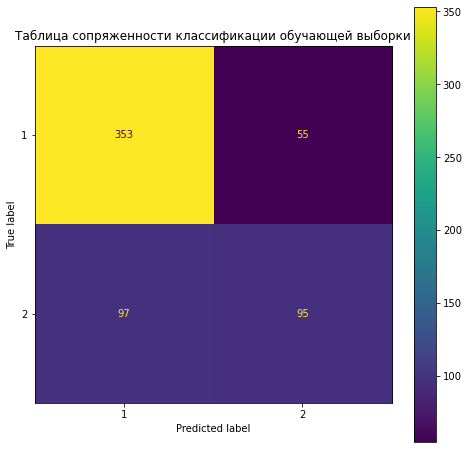

In [29]:
print("Оценка вероятности ошибочной классификации - доля неправильных меток:")
p21, p12 = err_prob_est(m1_rep, m2_rep, rep_n1, rep_n2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_training1, rep_q_training2):.5}")

print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est(alpha_rep, mean_z_rep, cov_matrix_rep_est, rep_q_training1, rep_q_training2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_training1, rep_q_training2):.5}")

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_rep, display_labels=["1", "2"]).plot(ax=ax)
plt.title("Таблица сопряженности классификации обучающей выборки")
plt.show()

### Классифицируем тестовую выборку

In [30]:
rep_classification_res = np.array([])
for vect in rep_test_sample:
    rep_classification_res = np.append(rep_classification_res, classify(vect, alpha_rep, threshold_rep))
    
rep_classification_res = rep_classification_res + 1
cm_rep = confusion_matrix(rep_test_sample_marks, rep_classification_res)

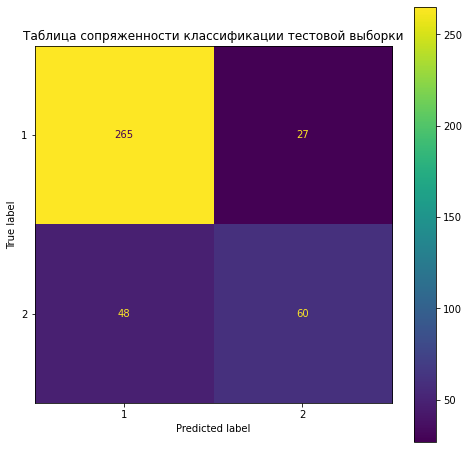

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_rep, display_labels=["1", "2"]).plot(ax=ax)
# fig.suptitle("Результаты классификации тестовой выборки(данные из репозитория)", fontsize=15)
plt.title("Таблица сопряженности классификации тестовой выборки")
plt.show()

In [32]:
tn_1, fp_1, fn_1, tp_1 = cm_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

rep_test_n1 = size_1 - rep_n1
rep_test_n2 = size_2 - rep_n2

print("Эмпирические вероятности ошибочной классификации:")
p21, p12 = err_prob_est(m1_rep, m2_rep, rep_test_n1, rep_test_n2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_training1, rep_q_training1):.5}")

Эмпирические вероятности ошибочной классификации:
        P(2|1) = 0.092466
        P(1|2) = 0.44444
	Общая вероятность ошибочной классификации: 0.3651


### Учет стоимости ошибочной классификации

In [33]:
c21 = 1
c12 = 2.33

In [34]:
# вычисление коэффициентов и среднего значения дискриминантной функции, порога принятия решения с учетом штрафов
def create_classifier_c(training1, training2, size1, size2, q1_, q2_, mu_est, cov_matrix_est):
    a = np.matmul(np.linalg.inv(cov_matrix_est), (mu_est[0] - mu_est[1]))
    mean_z1 = sum([discriminant_fun(a, training1[i, :]) for i in range(size1)]) / size1
    mean_z2 = sum([discriminant_fun(a, training2[i, :]) for i in range(size2)]) / size2
    mean_z = np.array([mean_z1, mean_z2])
    threshold = (mean_z1 + mean_z2) / 2.0 + np.log((q2_ * c12) / (q1_ * c21))
    return a, mean_z, threshold

def mahalanobis_err_prob_est_c(alpha, mean_z, cov_matrix_est, q1_, q2_): # оценка по расстоянию Махаланобиса с учетом штрафов
    K = np.log((q2_ * c12) / (q1_ * c21))
    mah_biased_est = mahalanobis_biased_est(alpha, mean_z, cov_matrix_est)
    p21 = norm.cdf((K - 0.5 * mah_biased_est) / mah_biased_est ** 0.5)
    p12 = norm.cdf((-K - 0.5 * mah_biased_est) / mah_biased_est ** 0.5)
    print(f"        P(2|1) = {p21:.5}")
    print(f"        P(1|2) = {p12:.5}")
    return p21, p12

def overall_err_prob_est_c(p21, p12, q1_, q2_): # оценка общей вероятности ошибки
    return q1_ * c21 * p21 + q2_ * c12 * p12

### Строим классификатор, оцениваем вероятность ошибочной классификации

In [37]:
alpha_rep, mean_z_rep, threshold_rep = create_classifier_c(rep_train_sample1, rep_train_sample2, rep_n1, rep_n2, rep_q_training1, rep_q_training2, mu_rep_est, cov_matrix_rep_est)
training_rep_classification_res = np.array([])

training_sample_rep = np.vstack((rep_train_sample1, rep_train_sample2))

for vect in training_sample_rep:
    training_rep_classification_res = np.append(training_rep_classification_res, classify(vect, alpha_rep, threshold_rep))
    
training_rep_classification_res = training_rep_classification_res + 1
cm_training_rep = confusion_matrix(rep_train_sample_marks, training_rep_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_training_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

Оценка вероятности ошибочной классификации - доля неправильных меток:
        P(2|1) = 0.30637
        P(1|2) = 0.23438
	Оценка общей вероятности ошибочной классификации: 0.28333

Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.31383
        P(1|2) = 0.25861
	Оценка общей вероятности ошибочной классификации: 0.29616


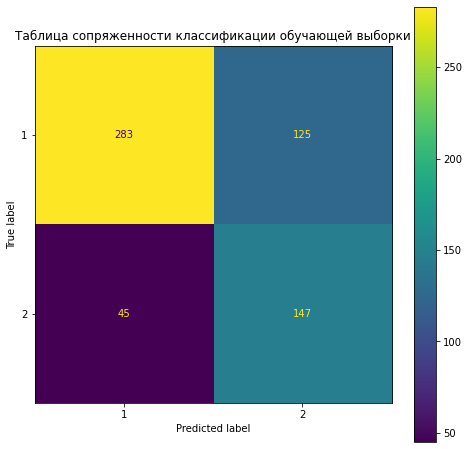

In [38]:
print("Оценка вероятности ошибочной классификации - доля неправильных меток:")
p21, p12 = err_prob_est(m1_rep, m2_rep, rep_n1, rep_n2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_training1, rep_q_training2):.5}")

print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est_c(alpha_rep, mean_z_rep, cov_matrix_rep_est, rep_q_training1, rep_q_training2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_training1, rep_q_training2):.5}")

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_rep, display_labels=["1", "2"]).plot(ax=ax)
plt.title("Таблица сопряженности классификации обучающей выборки")
plt.show()

### Классифицируем тестовую выборку

In [39]:
rep_classification_res = np.array([])
for vect in rep_test_sample:
    rep_classification_res = np.append(rep_classification_res, classify(vect, alpha_rep, threshold_rep))
    
rep_classification_res = rep_classification_res + 1
cm_rep = confusion_matrix(rep_test_sample_marks, rep_classification_res)

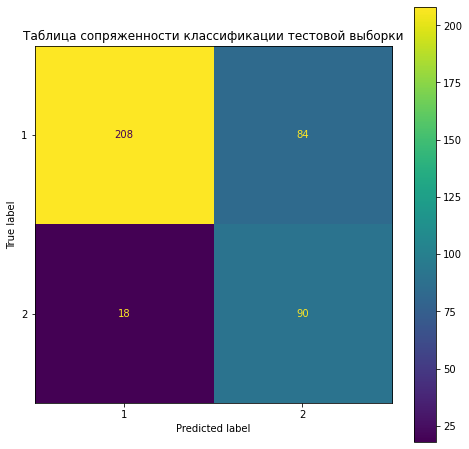

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_rep, display_labels=["1", "2"]).plot(ax=ax)
# fig.suptitle("Результаты классификации тестовой выборки(данные из репозитория)", fontsize=15)
plt.title("Таблица сопряженности классификации тестовой выборки")
plt.show()

In [41]:
tn_1, fp_1, fn_1, tp_1 = cm_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

rep_test_n1 = size_1 - rep_n1
rep_test_n2 = size_2 - rep_n2

print("Эмпирические вероятности ошибочной классификации:")
p21, p12 = err_prob_est(m1_rep, m2_rep, rep_test_n1, rep_test_n2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_training1, rep_q_training1):.5}")

Эмпирические вероятности ошибочной классификации:
        P(2|1) = 0.28767
        P(1|2) = 0.16667
	Общая вероятность ошибочной классификации: 0.30895


## a) Применим метод главных компонент

### К модельным данным

In [42]:
def mean(sample): # выборочное среднее
    return np.sum(sample, axis=0) / sample.shape[0]

def covar_matrix(sample): # выборочная матрица ковариации
    N, K = sample.shape[0], sample.shape[1]
    mu = mean(sample)
       
    cov = np.zeros((K, K))
    for j in range(K):
        for k in range(K):
            for i in range(N):
                cov[j, k] += (sample[i, j] - mu[j]) * (sample[i, k] - mu[k])
    cov = cov / (N - 1)
    return cov
def pca(features, n_components):
    print("features shape: ", features.shape)
    # применяем метод главных компонент
    mu = mean(features)
    features_centered = features - mu
    cov = covar_matrix(features_centered)

    values, vectors = np.linalg.eig(cov)
    print("Собственные числа:", sorted(values, reverse=True))
    eiges = sorted(list(zip(values, vectors.T)), key=lambda x: x[0], reverse=True)

    transform = np.vstack(list([eiges[i][1] for i in range(n_components)]))
#     + np.matmul(mu, transform.T)
    return np.matmul(features, transform.T)

In [43]:
def pca_reduce(sample, size, dim_, target_dim):
    mean = multivariate_mean(sample, size, dim_)
    sample_centered = sample - mean
    cov_matrix = sample_S(sample_centered, size, mean, dim_)

    eigen_val, eigen_vect = np.linalg.eig(cov_matrix)
    eigen = sorted(list(zip(eigen_val, eigen_vect.T)), key=lambda pair: pair[0], reverse=True)
    eigen_vals = np.array([eigen[i][0] for i in range(target_dim)])
    L = np.vstack(list([eigen[i][1] for i in range(target_dim)]))

    sample_pca = np.matmul(L, sample.T)
    sample_pca = sample_pca.T
    return sample_pca

In [54]:
target_dim = 2
train_pca_good1 = pca_reduce(training_sample_good1, n1, dim, target_dim)
train_pca_good2 = pca_reduce(training_sample_good2, n2, dim, target_dim)
test_pca_good = pca_reduce(test_sample_good, n, dim, target_dim)

# найдем долю сохранившейся информации
variance_ratio = np.trace(covar_matrix(train_pca_good1)) / np.trace(covar_matrix(training_sample_good1))
print(f"Доля сохранившейся дисперсии (для первой обучающей выборки): {variance_ratio:.6f}")
variance_ratio = np.trace(covar_matrix(train_pca_good2)) / np.trace(covar_matrix(training_sample_good2))
print(f"Доля сохранившейся дисперсии (для второй обучающей выборки): {variance_ratio:.6f}")

variance_ratio = np.trace(sample_S(test_pca_good, n, multivariate_mean(test_pca_good, n, target_dim),
                                   target_dim)) / np.trace(sample_S(test_sample_good, n, multivariate_mean(test_sample_good,
                                                                                                           n, dim), dim))

print(f"Доля сохранившейся дисперсии (для тестовой выборки): {variance_ratio:.6f}")

Доля сохранившейся дисперсии (для первой обучающей выборки): 0.717388
Доля сохранившейся дисперсии (для второй обучающей выборки): 0.724954
Доля сохранившейся дисперсии (для тестовой выборки): 0.766104


### Строим классификатор по обучающим выборкам меньшей размерности

In [ ]:
mu1_good_pca_est = multivariate_mean(train_pca_good1, n1, target_dim)
mu2_good_pca_est = multivariate_mean(train_pca_good2, n2, target_dim)
mu_good_pca_est = np.array([mu1_good_pca_est, mu2_good_pca_est])
# print(mu_est)
cov_matrix_good_pca_est = multivariate_cov_matrix(train_pca_good1, train_pca_good2, n1, n2, mu_good_pca_est, target_dim)

alpha_pca_good, mean_z_pca_good, threshold_pca_good = create_classifier(train_pca_good1, train_pca_good2, n1, n2, q_training1, q_training2, mu_good_pca_est, cov_matrix_good_pca_est)

In [ ]:
train_good_pca_classification_res = np.array([])
train_pca_good = np.vstack((train_pca_good1, train_pca_good2))

# Классифицируем обучающие выборки моделью, построенной по хорошо разделенным данным
for vect in train_pca_good:
    train_good_pca_classification_res = np.append(train_good_pca_classification_res, classify(vect, alpha_pca_good, threshold_pca_good))
cm_train_pca_good = confusion_matrix(training_sample_marks, train_good_pca_classification_res)
tn_1, fp_1, fn_1, tp_1 = cm_train_pca_good.ravel()
m1_pca_good = fp_1
m2_pca_good = fn_1

In [ ]:
print("Оценка вероятности ошибочной классификации - доля неправильных меток:")
p21, p12 = err_prob_est(m1_pca_good, m2_pca_good, n1, n2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_training1, q_training2):.5}")
print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est(alpha_pca_good, mean_z_pca_good, cov_matrix_good_pca_est, q_training1, q_training2)
print(f"\tОценка общей вероятности ошибочной классификации: {overall_err_prob_est(p21, p12, q_training1, q_training2):.5}")

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_train_pca_good, display_labels=["1", "2"]).plot(ax=ax)
# fig.suptitle("Результаты классификации обучающей выборки", fontsize=15)
ax.set_title("Таблица сопряженности классификации обучающей выборки")
plt.show()

### Классифицируем тестовую выборку

In [ ]:
good_pca_classification_res = np.array([])
for vect in test_pca_good:
    good_pca_classification_res = np.append(good_pca_classification_res, classify(vect, alpha_pca_good, threshold_pca_good))

cm_pca_good = confusion_matrix(test_sample_marks, good_pca_classification_res)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_pca_good, display_labels=["1", "2"]).plot(ax=ax)
fig.suptitle("Результаты классификации тестовой выборки", fontsize=15)
ax.set_title("Таблица сопряженности классификации тестовой выборки")
plt.show()

In [ ]:
tn_1, fp_1, fn_1, tp_1 = cm_pca_good.ravel()
m1_pca_good = fp_1
m2_pca_good = fn_1

print("Эмпирические вероятности ошибочной классификации:")
p21, p12 = err_prob_est(m1_pca_good, m2_pca_good, n * q1, n  * q2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, q1, q2):.5}")


### К данным из репозитория

In [61]:
target_dim = 3
features = rep_objects[:, :-1]
# features_pca = pca(features, target_dim)
features_pca = pca_reduce(features, rep_size, rep_dim, target_dim)
variance_ratio = np.trace(covar_matrix(features_pca)) / np.trace(covar_matrix(features))
print(f"Доля сохранившейся дисперсии (для тестовой выборки): {variance_ratio:.6f}")

objects_1 = features_pca[rep_marks == 1]
objects_2 = features_pca[rep_marks == 2]

rep_train1_pca, first_part_rep_test_pca = train_test_split(objects_1, train_size=rep_train_part, random_state=123)
rep_train2_pca, second_part_rep_test_pca = train_test_split(objects_2, train_size=rep_train_part, random_state=123)
rep_pca_n1, rep_pca_n2 = len(rep_train1_pca), len(rep_train2_pca)
print(rep_train1_pca.shape, rep_pca_n2)

# объединяем части тестовой выборки и зададаем для нее вектор с исходной классификацией
rep_test_pca = np.vstack([first_part_rep_test_pca, second_part_rep_test_pca])
print(len(first_part_rep_test_pca), len(second_part_rep_test_pca))
rep_test_pca_sample_marks = np.hstack([np.ones(len(first_part_rep_test_pca)), np.full(len(second_part_rep_test_pca), 2)])

rep_q_pca1 = rep_pca_n1 / (rep_pca_n1 + rep_pca_n2)
rep_q_pca2 = rep_pca_n2 / (rep_pca_n1 + rep_pca_n2)
print(rep_q_pca1, rep_q_pca2)

Доля сохранившейся дисперсии (для тестовой выборки): 0.986769
(420, 3) 180
280 120
0.7 0.3


### Строим классификатор по обучающим выборкам меньшей размерности

In [56]:
mu1_rep_pca_est = multivariate_mean(rep_train1_pca, rep_pca_n1, target_dim)
mu2_rep_pca_est = multivariate_mean(rep_train2_pca, rep_pca_n2, target_dim)
mu_rep_pca_est = np.array([mu1_rep_pca_est, mu2_rep_pca_est])
cov_matrix_rep_pca_est = multivariate_cov_matrix(rep_train1_pca, rep_train2_pca, rep_pca_n1, rep_pca_n2, mu_rep_pca_est, target_dim)

alpha_pca_rep, mean_z_pca_rep, threshold_pca_rep = create_classifier(rep_train1_pca, rep_train2_pca, rep_pca_n1, rep_pca_n2, rep_q_pca1, rep_q_pca2, mu_rep_pca_est, cov_matrix_rep_pca_est)

### Оценим вероятности ошибочной классификации полученного классификатора

##### Классифицируем обучающие выборки и найдем доли неправильно классифицированных объектов.

In [57]:
training_rep_pca_classification_res = np.array([])

training_sample_pca_rep = np.vstack((rep_train1_pca, rep_train2_pca))
rep_train_pca_marks = np.hstack([np.ones(rep_pca_n1), np.full(rep_pca_n2, 2)])

for vect in training_sample_pca_rep:
    training_rep_pca_classification_res = np.append(training_rep_pca_classification_res, classify(vect, alpha_pca_rep, threshold_pca_rep))
    
training_rep_pca_classification_res = training_rep_pca_classification_res + 1
print(len(training_rep_pca_classification_res))
cm_training_pca_rep = confusion_matrix(rep_train_pca_marks, training_rep_pca_classification_res)
print(cm_training_pca_rep)
tn_1, fp_1, fn_1, tp_1 = cm_training_pca_rep.ravel()
m1_pca_rep = fp_1
m2_pca_rep = fn_1

600
[[368  52]
 [ 94  86]]


Оценка вероятности ошибочной классификации:
        P(2|1) = 0.12381
        P(1|2) = 0.52222
	Общая вероятность ошибочной классификации: 0.45222

Оценка вероятности ошибочной классификации по расстоянию Махаланобиса:
        P(2|1) = 0.094707
        P(1|2) = 0.56595
	Общая вероятность ошибочной классификации: 0.46246


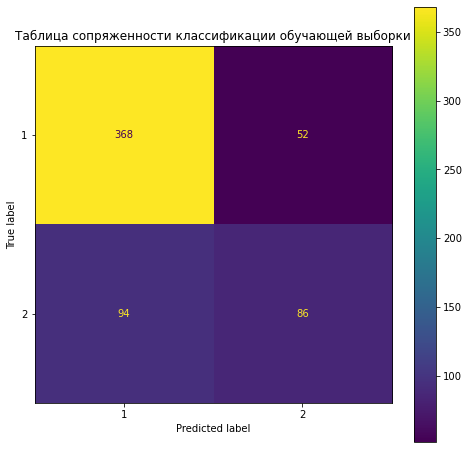

In [58]:
print("Оценка вероятности ошибочной классификации:")
p21, p12 = err_prob_est(m1_pca_rep, m2_pca_rep, rep_pca_n1, rep_pca_n2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_pca1, rep_q_pca1):.5}")

print("\nОценка вероятности ошибочной классификации по расстоянию Махаланобиса:")
p21, p12 = mahalanobis_err_prob_est(alpha_pca_rep, mean_z_pca_rep, cov_matrix_rep_pca_est, rep_q_pca1, rep_q_pca2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_pca1, rep_q_pca1):.5}")

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_training_pca_rep, display_labels=["1", "2"]).plot(ax=ax)
plt.title("Таблица сопряженности классификации обучающей выборки")
plt.show()

### Классифицируем тестовую выборку

In [ ]:
rep_pca_classification_res = np.array([])
for vect in rep_test_pca:
    rep_pca_classification_res = np.append(rep_pca_classification_res, classify(vect, alpha_pca_rep, threshold_pca_rep))
    
rep_pca_classification_res = rep_pca_classification_res + 1
cm_pca_rep = confusion_matrix(rep_test_pca_sample_marks, rep_pca_classification_res)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_pca_rep, display_labels=["1", "2"]).plot(ax=ax)
plt.title("Таблица сопряженности классификации тестовой выборки")
plt.show()

In [ ]:
tn_1, fp_1, fn_1, tp_1 = cm_pca_rep.ravel()
m1_rep = fp_1
m2_rep = fn_1

print("Эмпирические вероятности ошибочной классификации:")
p21, p12 = err_prob_est(m1_rep, m2_rep, size_1 - rep_n1, size_2 - rep_n2)
print(f"\tОбщая вероятность ошибочной классификации: {overall_err_prob_est(p21, p12, rep_q_pca1, rep_q_pca1):.5}")

In [ ]:
# # Первая обучающая выборка
# # rep_features, rep_marks = rep_objects[:, :-1], rep_objects[:, -1]
# mean_train_1 = multivariate_mean(rep_train_sample1, rep_n1, rep_dim)
# cov_matrix_train_1 = sample_S(rep_train_sample1, rep_n1, mean_train_1, rep_dim)
# rep_train_sample1_centered = rep_train_sample1 - mean_train_1
# eigen_val_train_1, eigen_vect_train_1 = np.linalg.eig(cov_matrix_train_1)
# # print(eigen_vect_train_1)
# # print(eigen_vect_train_1.T)
# # print(eigen_vect_train_1)
# # eigen_val_train_1_, eigen_vect_train_1_ = zip(*sorted(list(zip(eigen_val_train_1, eigen_vect_train_1.T)), key=lambda pair: pair[0], reverse=True))
# eigen_val_train_1_, eigen_vect_train_1_ = zip(*sorted(list(zip(eigen_val_train_1, eigen_vect_train_1.T)), reverse=True))
# print(eigen_val_train_1_)
# eigen_val_train_1_, eigen_vect_train_1_ = np.array(eigen_val_train_1_), np.array(eigen_vect_train_1_)
# vals_train_1 = eigen_val_train_1_[eigen_val_train_1_ > 1]
# print(f"Отобрали следующие {len(vals_train_1)} собcтвенных чисел: {vals_train_1}")

# # eiges = sorted(list(zip(eigen_val_train_1, eigen_vect_train_1.T)), key=lambda x: x[0], reverse=True)
# print()
# print(eigen_vect_train_1_.shape)
# # print(eigen_vect_train_1_.shape)
# # print(eigen_vect_train_1_.T.shape)

# # print(eiges[0][1].shape)

# transform_train_1 = np.vstack(list([eigen_vect_train_1_[i] for i in range(len(vals_train_1))]))
# print(transform_train_1.shape)
# print()
# rep_train_1_pca = np.matmul(rep_train_sample1_centered, transform_train_1.T)
# rep_train_1_pca_ = np.matmul(transform_train_1, rep_train_sample1_centered.T).T # по лекции
# print(rep_train_1_pca.shape, rep_train_1_pca_.shape)
# # print(f"{rep_train_1_pca[-8:, :] - rep_train_1_pca_[-8:, :]}")

# # print(rep_train_1_pca == rep_train_1_pca_)

# # # Вторая обучающая выборка
# # # rep_features, rep_marks = rep_objects[:, :-1], rep_objects[:, -1]
# # mean_train_2 = multivariate_mean(rep_train_sample2, rep_n2, rep_dim)
# # cov_matrix_train_2 = sample_S(rep_train_sample2, rep_n2, mean_train_2, rep_dim)
# # rep_train_sample2_centered = rep_train_sample2 - mean_train_2
# # eigen_val_train_2, eigen_vect_train_2 = np.linalg.eig(cov_matrix_train_2)
# # print(eigen_val_train_2[0])
# # print(eigen_vect_train_2[0])
# # # eigen_val_train_2_, eigen_vect_train_2_ = zip(*sorted(list(zip(eigen_val_train_2, eigen_vect_train_2.T)), key=lambda pair: pair[0], reverse=True))
# # eigen_val_train_2_, eigen_vect_train_2_ = zip(*sorted(list(zip(eigen_val_train_2, eigen_vect_train_2.T)), reverse=True))

# # vals_train_2 = eigen_val_train_2[eigen_val_train_2 > 1]
# # print(f"Отобрали следующие {len(vals_train_2)} собcтвенных чисел: {vals_train_2}")

# # eiges = sorted(list(zip(eigen_val_train_2, eigen_vect_train_2.T)), key=lambda x: x[0], reverse=True)
# # print(eigen_val_train_2_[0])
# # print(eigen_vect_train_2_[0])
# # # print(eiges[0][1].shape)